In [1]:
cd ..

/home/yann/IVISpaces


In [2]:
import numpy as np
import math
import torch
from torch import nn

from torch.distributions.multivariate_normal import MultivariateNormal


import scipy.stats as stats
import matplotlib
import matplotlib.pyplot as plt

from Models import BigGenerator

from datetime import datetime

from torch.utils.data import Dataset

from Models import get_mlp
from Tools import NormalLogLikelihood
from Metrics import KL, evaluate_metrics, Entropy

from Experiments import get_setup

from Inference.IVI import IVI

from tqdm import trange

import timeit

In [3]:
def PlotCI(x_pred, y_pred, x, y, device):
    N=y_pred.shape[0]-1
    print(N)
    m_3=int(0.001*N)
    M_3=N-m_3
    m_2=int(0.021*N)
    M_2=N-m_2
    m_1=int(0.136*N)
    M_1=N-m_1

    x_pred=x_pred.squeeze()

    pred,_=y_pred.sort(dim=0)
    y_mean=y_pred.mean(dim=0).squeeze().cpu()
    y_3=pred[m_3,:].squeeze().cpu()
    Y_3=pred[M_3,:].squeeze().cpu()

    y_2=pred[m_2,:].squeeze().cpu()
    Y_2=pred[M_2,:].squeeze().cpu()

    
    y_1=pred[m_1,:].squeeze().cpu()
    Y_1=pred[M_1,:].squeeze().cpu()


    fig, ax=plt.subplots()
    ax.fill_between(x_pred.cpu(), y_3, Y_3, facecolor='springgreen', alpha=0.1)
    ax.fill_between(x_pred.cpu(), y_2, Y_2, facecolor='springgreen', alpha=0.1)
    ax.fill_between(x_pred.cpu(), y_1, Y_1, facecolor='springgreen', alpha=0.1)
    plt.plot(x_pred.cpu(),y_mean, color='springgreen')

    plt.grid(True, which='major', linewidth=0.5)

#    plt.xlim(-4,4)
    plt.ylim(-5, 5)
    plt.scatter(x.cpu(), y.cpu() , marker='+',color='black',zorder=4)
    return fig



In [4]:
#hyperparameters

#predictive model
layerwidth=20
nblayers=4
activation=nn.ReLU()

#generative model
lat_dim=5



#optimizer
learning_rate=0.01

#scheduler
patience=30
lr_decay=.5#.7
min_lr= 0.0001
n_epochs=1000#2000


#loss hyperparameters
n_samples_LL=100 #nb of predictor samples for average LogLikelihood

n_samples_KL=100 #nb of predictor samples for KL divergence
kNNE=1 #k-nearest neighbour



# Setup #

In [5]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

date_string = datetime.now().strftime("%Y-%m-%d-%H:%M")

256.3990902709961 6.654996536537532


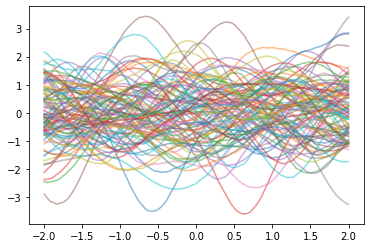

In [6]:
class GaussianProcess(nn.Module):
    def __init__(self, mean, lengthscale, noise=0.05):
        super(GaussianProcess, self).__init__()
        self.ls=lengthscale
        self.mean=mean
        self.var=noise**2

    def covar_matrix(self,x):
        K=torch.cdist(x.div(self.ls),x.div(self.ls),p=2).pow_(2).div_(-2).exp_()
        return K+self.var*torch.eye(x.shape[0], device=x.device)##
    
    def log_prob(self,inputs,f):
        GP_inputs=MultivariateNormal(loc=self.mean*torch.ones(inputs.shape[0], device=inputs.device),covariance_matrix=self.covar_matrix(inputs))
        return GP_inputs.log_prob(f)
    def forward(self, inputs, n=1):
        GP_inputs=MultivariateNormal(loc=self.mean*torch.ones(inputs.shape[0], device=inputs.device),covariance_matrix=self.covar_matrix(inputs))
        return GP_inputs.sample((n,)).squeeze()
    
prior=GaussianProcess(mean=torch.tensor(0.),lengthscale=.5, noise=0.01)    
inputs=torch.linspace(-2,2.,100).unsqueeze(-1).to(device)
LPs=[]

for _ in range(100):
    f=prior(inputs).cpu()
    plt.plot(inputs.cpu(),f.cpu(),alpha=0.5)
    LPs.append(prior.log_prob(inputs.cpu(),f).item())
print(np.mean(LPs),np.std(LPs))   

In [7]:
#UCI datasets: ['boston','concrete', 'energy', 'powerplant',  'wine', 'yacht']
dataset='foong' 

setup_ = get_setup(dataset)
setup=setup_.Setup(device) 

x_train, y_train=setup.train_data()
x_test, y_test=setup.test_data()

train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
test_dataset = torch.utils.data.TensorDataset(x_test, y_test)
train_input = torch.utils.data.TensorDataset(x_train)

sigma_noise=setup.sigma_noise
print(sigma_noise)
sigma_prior=1.#setup.sigma_prior    

size_data=len(train_dataset)
#batch_size
batch_size=30


n_samples_FU=30 #number of OOD inputs for evaluation of the KL in predictor space
n_train_input_samples_KL=0 #must be lower or equal to batch_size

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)


std_y_train = torch.tensor(1.)
if hasattr(setup, '_scaler_y'):
    std_y_train=torch.tensor(setup._scaler_y.scale_, device=device).squeeze().float()

0.1


# Predictive model #

In [8]:
input_dim=x_train.shape[1]
param_count, model = get_mlp(input_dim, layerwidth, nblayers, activation)

print('input dim: '+str(input_dim))
print('param count: '+str(param_count))

input dim: 1
param count: 1321


# ELBO

## Average Log Likelihood

In [9]:
#average log likelihood loss
def loss(x_data, y_data, GeN):
    r"""

    Parameters:
    x_data (Tensor): tensor of size N X D
    y_data (Tensor): tensor of size N X 1
    GeN: hypernet generating weights for primary network 'model'


    Returns:
    (float):   mean of loglikelihood
    """

    y_pred=model(x_data,GeN(n_samples_LL))
    log_proba=NormalLogLikelihood(y_pred, y_data, sigma_noise).sum(1)
    return log_proba.mean()

## Kullback-Leibler divergence in Predictor space

In [32]:

# sampling of OOD inputs on which evaluate predictors for the Hilbert distance
"""
##for toy example
n_samples_FU=30
def projection(theta0,theta1):
    #batch sample OOD    
    M=2.
    m=-2.
    X_ood = torch.rand(n_samples_FU,input_dim).to(device) * (M-m) + m    
    X=X_ood
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj
"""
#predictor space KL
def projection(theta0,theta1, x_data):
    #batch sample OOD   
    n_ood=n_samples_FU
#    epsilon=0.1
    M = 2.#x_train.max(0, keepdim=True)[0]+epsilon
    m = -2.#x_train.min(0, keepdim=True)[0]-epsilon
    X_ood = torch.rand(n_ood,input_dim).to(device) * (M-m) + m    

    X=torch.cat([X_ood,x_data[:n_train_input_samples_KL,:]])
    
    #compute projection on both paramters with model
    theta0_proj=model(X, theta0).squeeze(2)
    theta1_proj=model(X, theta1).squeeze(2)
    return theta0_proj, theta1_proj

def projection_train(theta0,theta1,x_data):
    #batch sample OOD

    #compute projection on both paramters with model
    theta0_proj=model(x_data, theta0).squeeze(2)
    theta1_proj=model(x_data, theta1).squeeze(2)
    return theta0_proj, theta1_proj

n_ood=50
def ood_input(n_ood=n_ood):
    M =2.
    m =-2.
    return torch.rand(n_ood,input_dim).to(device) * (M-m) + m  


def kl(GeN):
    theta=GeN(n_samples_KL) #variationnel
    X_ood=ood_input()
    f_theta=model(X_ood, theta).squeeze(2)
    f_prior=prior(X_ood,n=n_samples_KL)
    k=KL(f_theta,f_prior,k=kNNE,device=device)
    return k


def kl_(GeN, n_ood=n_ood):
    theta=GeN(n_samples_KL) #variationnel
    X_ood=ood_input(n_ood)
    f_theta=model(X_ood, theta).squeeze(2)
    H=Entropy(f_theta,k_MC=n_ood)
    logtarget=prior.log_prob(X_ood,f_theta).mean()
    return -H-logtarget


def kl_train(GeN,x_data):

    theta=GeN(x_data.shape[0]) #variationnel
    theta_prior=prior(x_data.shape[0]) #prior

    theta_proj, theta_prior_proj = projection_train(theta, theta_prior,x_data)

    K=KL(theta_proj, theta_prior_proj,k=kNNE,device=device)
    return K

models_HMC = torch.load('Results/HMC_models.pt')
HMC=models_HMC[dataset][:500,:].to(device)
def kl_HMC_train(GeN,x_data):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection_train(theta, HMC ,x_data)

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

def kl_HMC_OOD(GeN):

    theta=GeN(HMC.shape[0]) #variationnel

    theta_proj, theta_HMC_proj = projection(theta, HMC, torch.empty((0,input_dim)).to(device))

    K=KL(theta_proj, theta_HMC_proj,k=kNNE,device=device)
    return K

## ELBO ##

In [33]:
#ELBO

beta=1.
def ELBO(x_data, y_data, GeN, beta=beta):
    alpha=(len(x_data)/size_data)
    Average_LogLikelihood=loss(x_data, y_data, GeN)
    the_KL=kl_(GeN)
    the_ELBO= - Average_LogLikelihood+ alpha*the_KL
    return the_ELBO, the_KL, Average_LogLikelihood 


# Generative model #

In [34]:
#generative model
GeN = BigGenerator(lat_dim,param_count,device).to(device)
print(GeN)

BigGenerator(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=20, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=20, out_features=40, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=40, out_features=1321, bias=True)
  )
)


# Optimizer

In [35]:
optimizer = torch.optim.Adam(GeN.parameters(), lr=learning_rate)



Run=IVI(train_loader, ELBO, optimizer)

# Scheduler #

In [36]:
#scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=patience, factor=lr_decay, verbose=True, min_lr=min_lr)


# TRAINING #

In [37]:
KLs=[]
ELBOs=[]
LLs=[]
LRs=[]

test_metrics={'RMSE':[],
              'PICP':[],
              'MPIW':[],
              'LPP':[],
              'WAIC':[]
             }
start = timeit.default_timer()
with trange(n_epochs) as tr:
    for t in tr:
        
        theta=GeN(1000).detach()
        y_pred=model(x_test,theta)
        metrics=evaluate_metrics(y_pred, torch.tensor(sigma_noise).view(1,1,1), y_test,  std_y_train, device='cpu', std=False)
        
        for m,v in metrics.items():
            test_metrics[m].append(v)
        
        scores=Run.run(GeN)
        tr.set_postfix(ELBO=scores['ELBO'], LogLike=scores['LL'], KL=scores['KL'], lr=scores['lr'])
        ELBOs.append(scores['ELBO'])
        KLs.append(scores['KL'])
        LLs.append(scores['LL'])
        LRs.append(scores['lr'])
        scheduler.step(scores['ELBO'])
        if scores['lr'] <= 1e-4:
            break
stop = timeit.default_timer()
execution_time = stop - start



 14%|█▎        | 136/1000 [00:20<02:08,  6.74it/s, ELBO=-20.1, KL=9.27, LogLike=22.4, lr=0.005]

Epoch   135: reducing learning rate of group 0 to 5.0000e-03.


 35%|███▍      | 346/1000 [00:52<01:36,  6.80it/s, ELBO=-20.4, KL=-2.55, LogLike=19.8, lr=0.0025]

Epoch   345: reducing learning rate of group 0 to 2.5000e-03.


 40%|███▉      | 396/1000 [01:00<01:31,  6.57it/s, ELBO=-27.3, KL=-8.53, LogLike=25.1, lr=0.00125]

Epoch   395: reducing learning rate of group 0 to 1.2500e-03.


 45%|████▌     | 452/1000 [01:09<01:23,  6.57it/s, ELBO=-30.1, KL=-18.1, LogLike=25.6, lr=0.000625]

Epoch   451: reducing learning rate of group 0 to 6.2500e-04.


 48%|████▊     | 484/1000 [01:13<01:17,  6.67it/s, ELBO=-30.5, KL=-18.9, LogLike=25.8, lr=0.000313]

Epoch   483: reducing learning rate of group 0 to 3.1250e-04.


 52%|█████▏    | 516/1000 [01:18<01:16,  6.36it/s, ELBO=-28.9, KL=-12.7, LogLike=25.7, lr=0.000156]

Epoch   515: reducing learning rate of group 0 to 1.5625e-04.


 55%|█████▍    | 546/1000 [01:23<01:09,  6.54it/s, ELBO=-29.3, KL=-14.2, LogLike=25.7, lr=0.0001]  

Epoch   546: reducing learning rate of group 0 to 1.0000e-04.


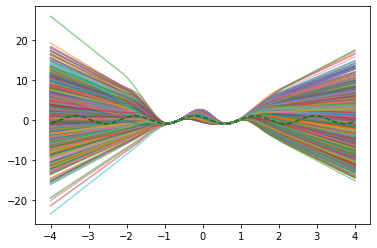

In [38]:
inputs=torch.linspace(-4.,4.,500).unsqueeze(-1).to(device)
for _ in range(1000):
    f=model(inputs,GeN(1)).squeeze().detach().cpu()
    plt.plot(inputs.cpu(),model(inputs,GeN(1)).squeeze().detach().cpu(),alpha=0.5)
plt.plot(inputs.cpu(), torch.cos(4.0*(inputs+0.2)).cpu(),'--',color='green')


999


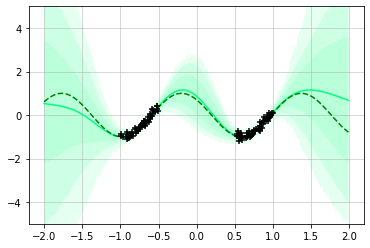

In [40]:
%matplotlib inline
theta=GeN(1000).detach()
x_pred=torch.arange(-2.,2.,0.01).to(device)
y_pred=model(x_pred,theta).detach()
y_pred+=sigma_noise*torch.randn_like(y_pred)
fig=PlotCI(x_pred, y_pred, x_train, y_train, device)
ax=fig.get_axes()[0]
ax.plot(x_pred.cpu(), torch.cos(4.0*(x_pred.cpu()+0.2)),'--', color='green')

# Results on test #

In [41]:
#compute metrics on test

results={}
log_device='cpu'
theta=GeN(2000).detach()
y_pred=model(x_test,theta)
metrics=evaluate_metrics(y_pred, torch.tensor(sigma_noise).view(1,1,1), y_test,  std_y_train, device='cpu', std=False)
results.update({dataset:metrics})
results[dataset].update({'time [s]':execution_time})

print(dataset)
for m, r in metrics.items():
    print(m+': '+str(r))

foong
RMSE: 0.39559733867645264
LPP: -0.3201502859592438
WAIC: -27863.39046278596
PICP: 0.9866666793823242
MPIW: 3.0112786293029785
time [s]: 83.4829177763313


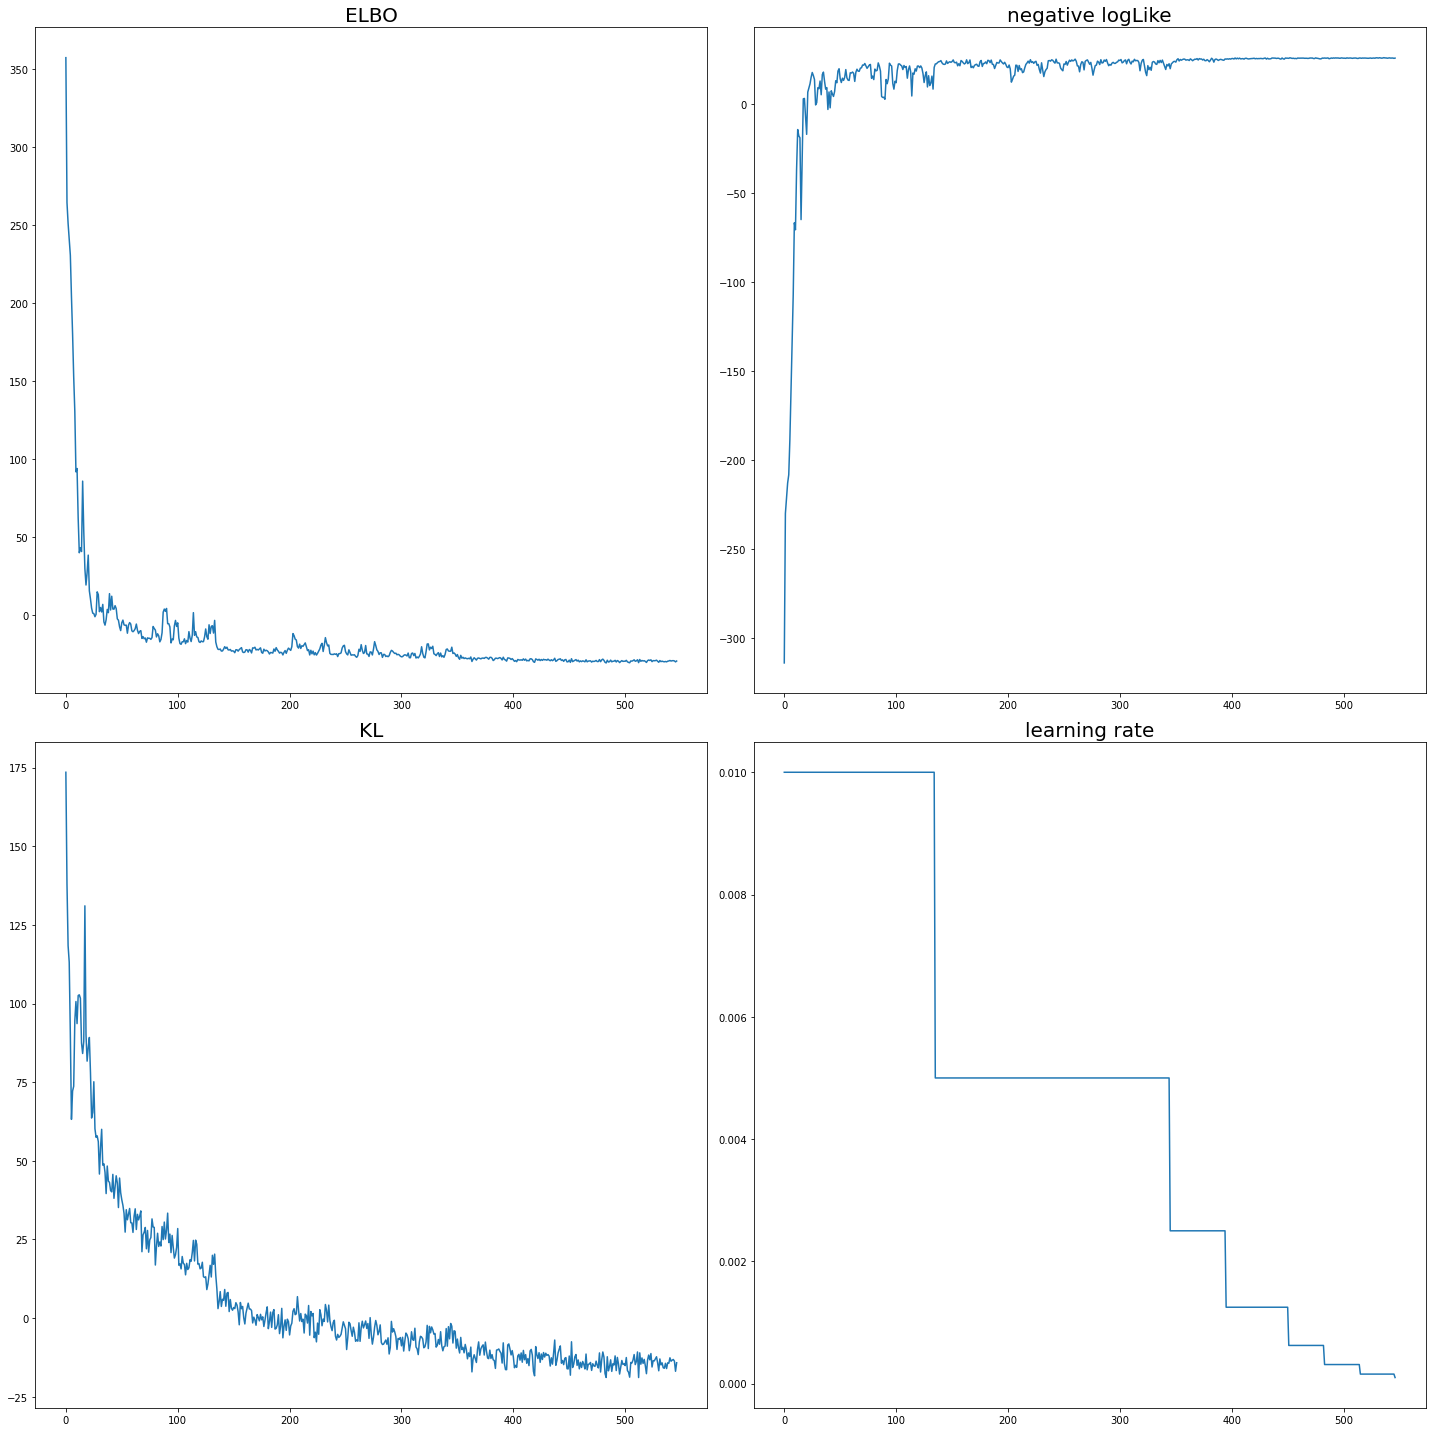

In [42]:
training={'ELBO':ELBOs,'KL':KLs, 'LR':LRs, 'LL':LLs}
time_line=torch.arange(0,len(training['ELBO']),1)

ELBO_=torch.as_tensor(training['ELBO'])
KL_=torch.as_tensor(training['KL'])
LR_=torch.as_tensor(training['LR'])
LL_=torch.as_tensor(training['LL'])

fig, ax =plt.subplots(2,2, figsize=(20,20))
ax[0,0].plot(time_line,ELBO_)
ax[0,0].set_title('ELBO', fontsize=20)
ax[0,1].plot(time_line,LL_)
ax[0,1].set_title('negative logLike', fontsize=20)
ax[1,0].plot(time_line,KL_)
ax[1,0].set_title('KL', fontsize=20)
ax[1,1].plot(time_line,LR_)
ax[1,1].set_title('learning rate', fontsize=20)
fig.tight_layout()

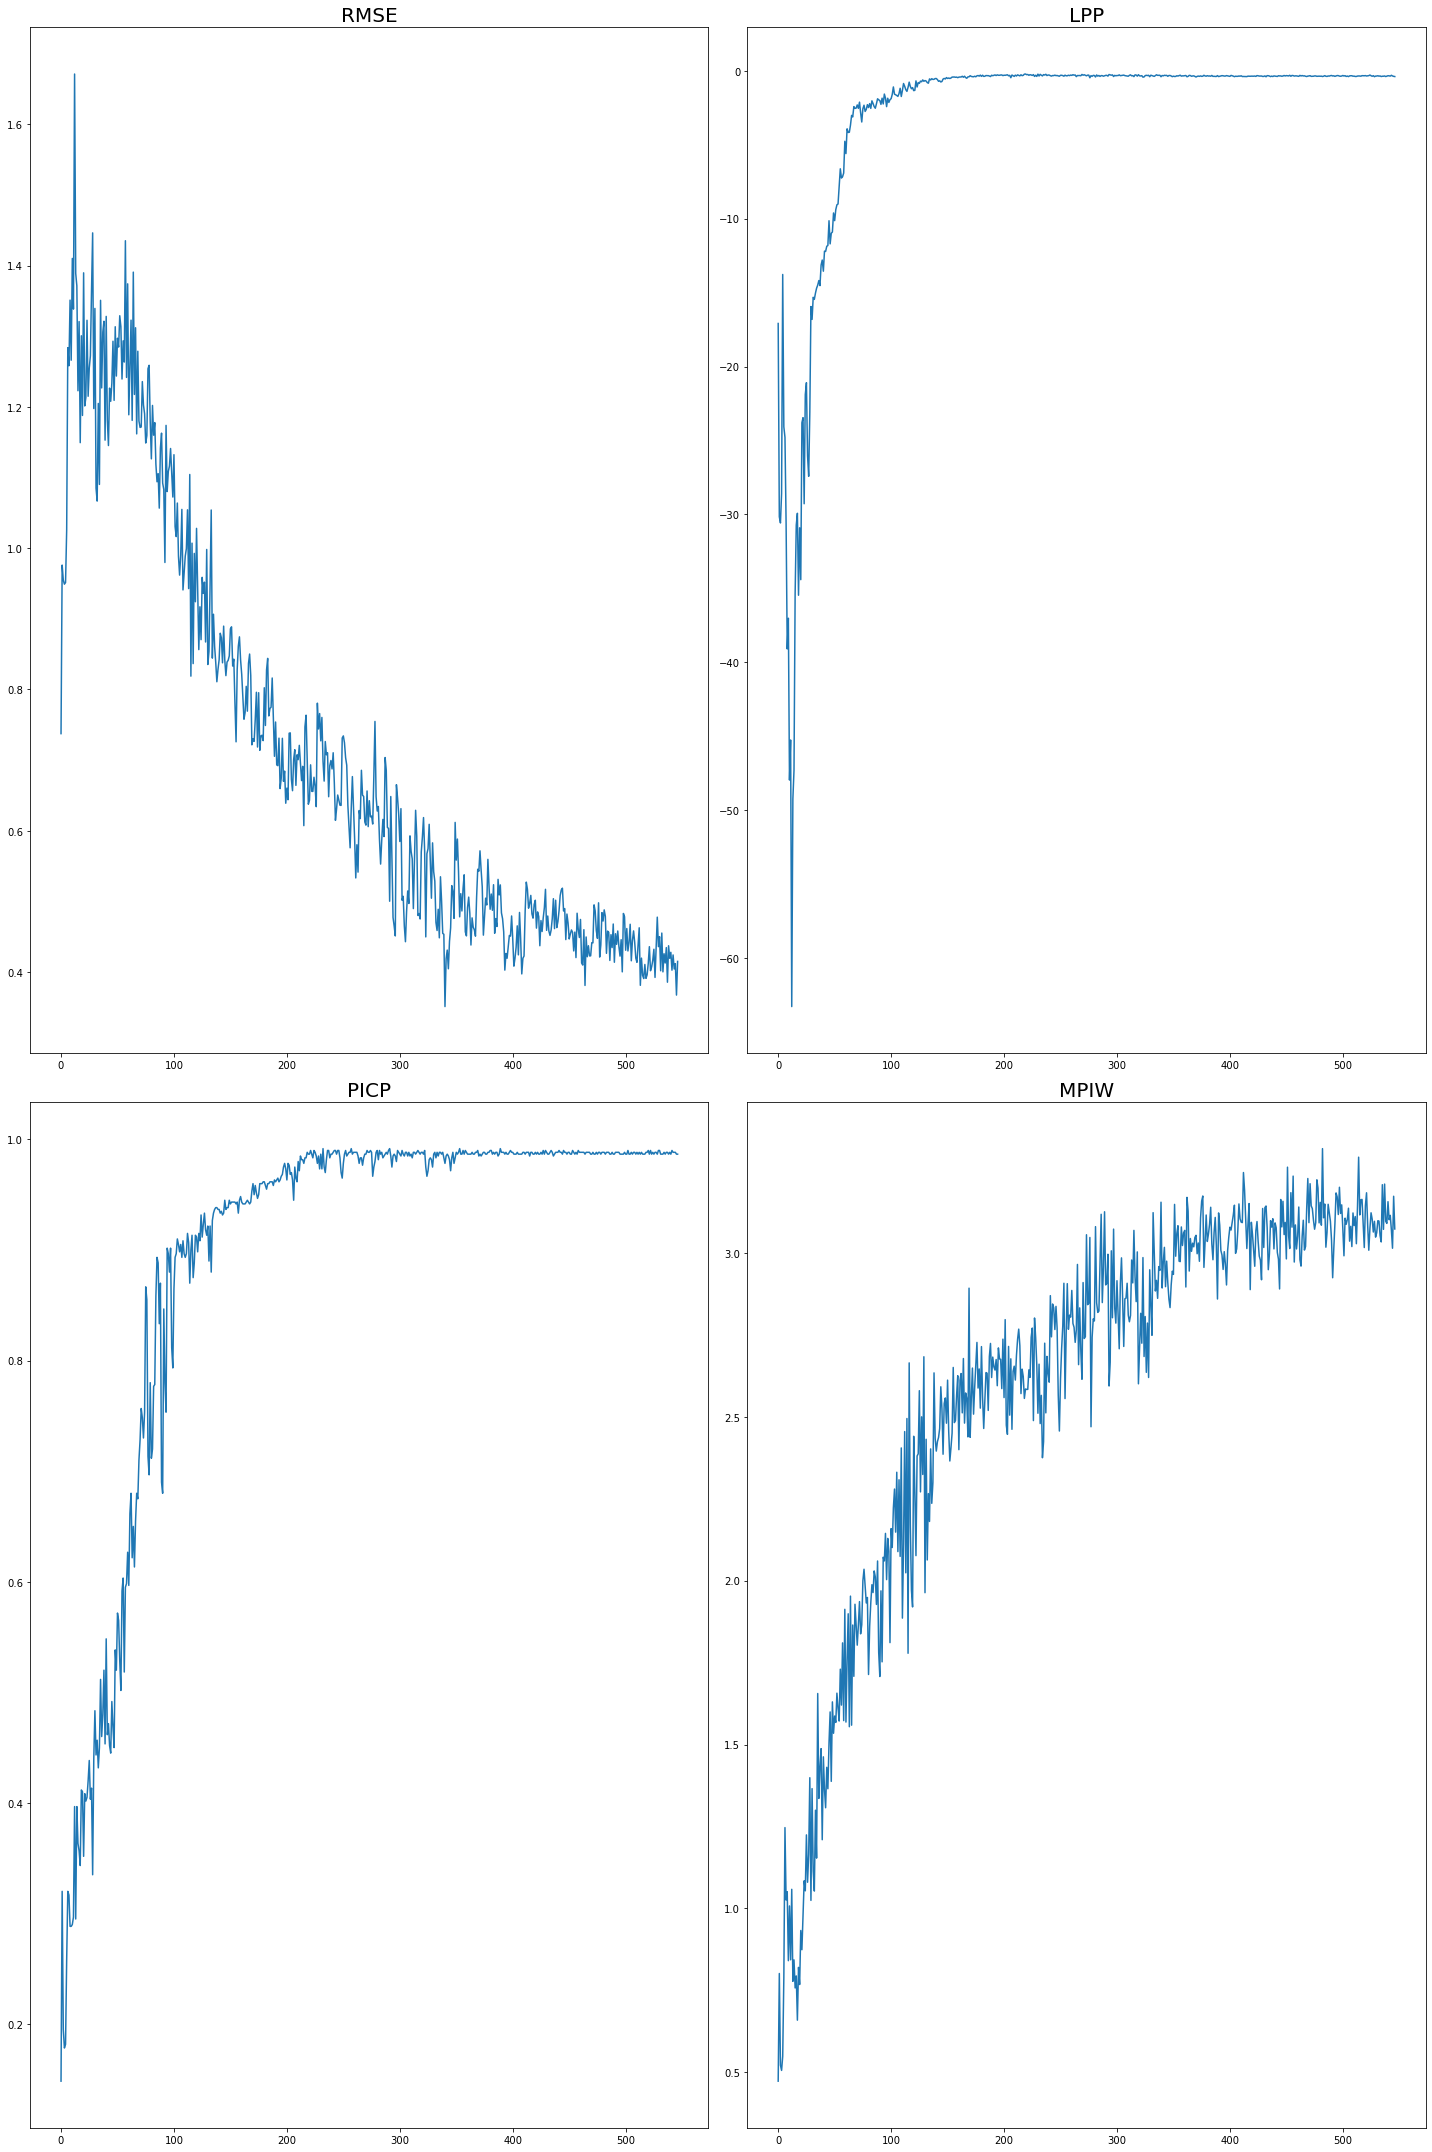

In [43]:
time_line=torch.arange(0,len(test_metrics['RMSE']),1)

for m,v in test_metrics.items():
    test_metrics[m]=torch.as_tensor(v)

fig, ax =plt.subplots(2,2, figsize=(20,30))
m='RMSE'
ax[0,0].plot(time_line,test_metrics[m])
ax[0,0].set_title(m, fontsize=20)
m='LPP'
ax[0,1].plot(time_line,test_metrics[m])
ax[0,1].set_title(m, fontsize=20)
m='PICP'
ax[1,0].plot(time_line,test_metrics[m])
ax[1,0].set_title(m, fontsize=20)
m='MPIW'
ax[1,1].plot(time_line,test_metrics[m])
ax[1,1].set_title(m, fontsize=20)
fig.tight_layout()

# Uncertainty vs error #

In [47]:
from torch.distributions import Uniform

sigma_noise_data = torch.tensor(0.1)
N = 25
M=100

X_l=Uniform(torch.tensor([-1.0]), torch.tensor([-.5])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_r=Uniform(torch.tensor([.5]), torch.tensor([1.0])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_in=torch.cat([X_l,X_r]).to(device)
X_middle=Uniform(torch.tensor([-.5]), torch.tensor([.5])).sample(sample_shape=torch.Size([int(200)])).squeeze().to(device)
X_l_=Uniform(torch.tensor([-2.0]), torch.tensor([-1.])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_r_=Uniform(torch.tensor([1.]), torch.tensor([2.])).sample(sample_shape=torch.Size([int(M)])).squeeze()
X_out=torch.cat([X_l_,X_r_]).to(device)
X_all=Uniform(torch.tensor([-2.0]), torch.tensor([2.])).sample(sample_shape=torch.Size([int(1000)])).squeeze().to(device)
def f(X):
    y_ = torch.cos(4.0*(X+0.2)) 
    return y_ + sigma_noise_data* torch.randn_like(y_)

y_in=f(X_in).unsqueeze(-1)
y_middle=f(X_middle).unsqueeze(-1)
y_out=f(X_out).unsqueeze(-1)
y_all=f(X_all)
print(X_in.shape, y_in.shape)

torch.Size([200]) torch.Size([200, 1])


torch.Size([1000])
torch.Size([500, 1000, 1])
torch.Size([1000, 500, 500])
a: torch.Size([1000, 500])
torch.Size([1000])
torch.Size([1000])


Text(0.5, 0, 'Uncertainty (Diff Entropy)')

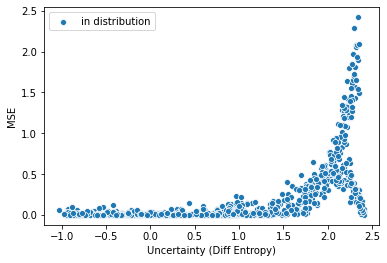

In [52]:
import seaborn as sns
X=[X_all]#[X_in,X_middle,X_out]
y=[y_all]#[y_in,y_middle,y_out]

label=['in distribution', 'in between', 'out of distribution']

def Entropy_(theta,k=1,k_MC=1,device='cpu'):
    """
    Parameters:
        theta (Tensor): Samples, Batch x N X D
        k (Int): ordinal number

    Returns:
        (Tensor) H of size B, with H[b] k-Nearest Neighbour Estimation of the entropy of theta[b,:,:]

    """
    nb_samples=theta.shape[-2]
    dim=theta.shape[-1]
    kMC=torch.tensor(float(k_MC))
    D=torch.cdist(theta,theta)
    print(D.shape)
    a = torch.topk(D, k=k+1, dim=-1, largest=False, sorted=True)[0][:,:,-1]
    print('a: {}'.format(a.shape))
    d=torch.as_tensor(float(dim), device=device)
    K=torch.as_tensor(float(k), device=device)
    N=torch.as_tensor(float(nb_samples), device=device)
    pi=torch.as_tensor(math.pi, device=device)
    lcd = d/2.*pi.log() - torch.lgamma(1. + d/2.0)#-d/2*K_MC.log()
    return torch.log(N) - torch.digamma(K) + lcd + d/nb_samples*a.div(torch.sqrt(kMC)).log().sum(-1)


Hs=[]
AEs=[]
for i in range(len(X)):
    theta=GeN(500).detach()
    pred_=model(X[i],theta)
    pred=pred_+sigma_noise*torch.randn_like(pred_)

    print(X[i].shape)
    M = pred.shape[0]
    M_low = int(0.025 * M)
    M_high = int(0.975 * M)

    y_pred_s, _ = pred_.sort(dim=0)

    y_low = y_pred_s[M_low, :].squeeze().to(device)
    y_high = y_pred_s[M_high, :].squeeze().to(device)

    PIW=(std_y_train*(y_high-y_low))

    print(pred.shape)
    H=(Entropy_(pred.transpose(0,1),k=20))
    print(H.shape)
    Hs.append(H)
    
    STD=(pred.std(0).squeeze())
    pred=model(X[i],theta)
    marginal_se=(pred-y[i])**2
    empirical_sqloss=marginal_se.mean()
    MSE=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze())**2)
    L1error=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze()).abs())
    print(MSE.shape)
    AEs.append(L1error)
    ax=sns.scatterplot(H.cpu().numpy(),MSE.cpu().numpy(), label=label[i])
    
ax.set_ylabel('MSE')
ax.set_xlabel('Uncertainty (Diff Entropy)')



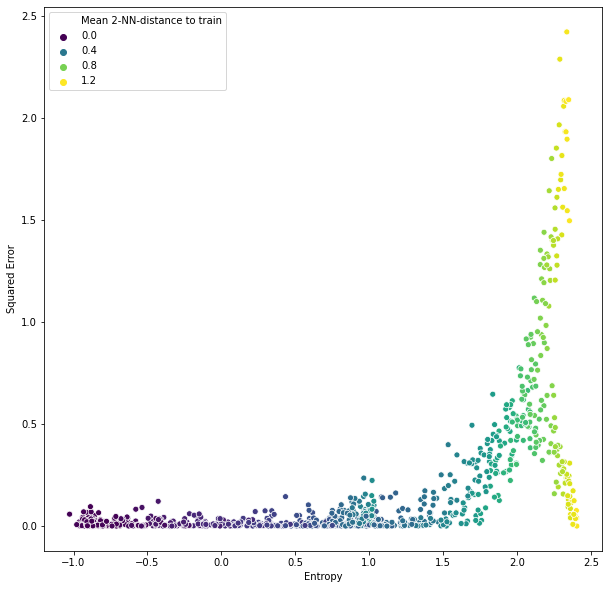

In [78]:
dists=torch.cdist(X_all.view(-1,1),x_train.view(-1,1))
knn=torch.topk(dists, k=2, dim=-1, largest=False, sorted=True)[0].mean(dim=1)

import matplotlib.cm as cm
cmap = cm.viridis
import pandas as pd

data=[]
for i in range(len(X_all)):
    data.append({'Entropy':H[i].item(), 'Squared Error':MSE[i].item(), 'Mean 2-NN-distance to train':knn[i].item()})

df=pd.DataFrame(data=data)
colors=knn.div_(knn.max())
colors

plt.subplots(figsize=(10,10))
sns.scatterplot(data=df, x='Entropy', y='Squared Error', hue='Mean 2-NN-distance to train', palette=cmap)
#ax=sns.scatterplot(H.cpu().numpy(),MSE.cpu().numpy(), hue=knn.cpu(), palette=cmap)
#ax.set_ylabel('MSE')
#ax.set_xlabel('Uncertainty (Diff Entropy)')


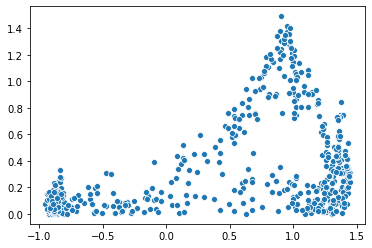

In [73]:
H_=torch.cat(Hs)
AE_=torch.cat(AEs)
sns.scatterplot(H_.cpu(),AE_.cpu())

# HydraNet


In [79]:
#NN with multiple heads
def build_hydra(num_inputs,num_heads, num_outputs=1, direct_variance_head=False):
    class HydraHead(torch.nn.Module):
        def __init__(self, n_o):
            super(HydraHead, self).__init__()

            self.head_net = torch.nn.Sequential(
                     torch.nn.Linear(20, 20),
                     torch.nn.SELU(),
                     torch.nn.Linear(20, n_o))
            
        def forward(self, x):
            return self.head_net(x)
            
    class HydraNet(torch.nn.Module):
        def __init__(self, num_inputs,num_heads, num_outputs, direct_variance_head=False):
            super(HydraNet, self).__init__()
            self.shared_net = torch.nn.Sequential(
                torch.nn.Linear(num_inputs, 20),
                torch.nn.SELU(),
                torch.nn.Linear(20, 20),
                torch.nn.SELU()
            )
            #Initialize the heads
            self.num_heads = num_heads
            self.num_outputs = num_outputs
            self.heads = torch.nn.ModuleList([HydraHead(n_o=num_outputs) for h in range(num_heads)])

            if direct_variance_head:
                self.direct_variance_head = HydraHead(n_o=1)
            else:
                self.direct_variance_head = None
            
        def forward(self, x):
            y = self.shared_net(x)
            y_out = [head_net(y) for head_net in self.heads]

            #Append the direct variance to the end of the heads
            if self.direct_variance_head is not None:
                y_out.append(self.direct_variance_head(y))

            return torch.cat(y_out, 1)
            
    net = HydraNet(num_inputs,num_heads, num_outputs, direct_variance_head)
    return net

#NLL loss for HydraNet
class GaussianHydraLoss(torch.nn.Module):
    def __init__(self):
        super(GaussianHydraLoss, self).__init__()
    
    #Based on negative log of normal distribution
    def forward(self, input, target):

        mean = input[:, :-1]
        sigma2 = torch.log(1. + torch.exp(input[:, [-1]])) + 1e-6 #torch.abs(input[:, [-1]]) + 1e-6

        sigma2 = sigma2.repeat([1, mean.shape[1]])
        #sigma2 = torch.nn.functional.softplus(input[:, :, 1]) + 1e-4
        loss = 0.5*(mean - target)*((mean - target)/sigma2) + 0.5*torch.log(sigma2)
        return loss.mean()

In [80]:
def train_minibatch(model, loss, optimizer, x_val, y_val):

    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)

    output = loss.forward(fx, y)

    # Backward
    output.backward()

    # Update parameters
    optimizer.step()

    return output.item() 

def test_hydranet_sigma(x_test, model):
    num_test_samples = x_test.shape[0]
    #Evaluate the model
    model.eval()
    y_t = model.forward(x_test).data.cpu().numpy()
    n = model.num_heads
    
    mu_i = y_t[:,:-1] # outputs from the n heads
    mu_star = np.mean(mu_i, axis=1) #The means of the n hydra head predictions
    
    sigma2_i = np.log(1. + np.exp(y_t[:,-1])) + 1e-6 #last head gives sigma2_i
    sigma2_hydra = np.var(mu_i, axis=1, ddof=1) #variance of hydranet outputs
    sigma2_star = sigma2_i + sigma2_hydra
    sigma_star = np.sqrt(sigma2_star) #variance of convolution of the two normal measures

    return (mu_star, sigma_star),np.sqrt(sigma2_hydra),np.sqrt(sigma2_i)

def compute_nll(y_true, y_pred, sigma_pred):
    sigma2 = sigma_pred**2
    losses = (0.5/(sigma2))*(y_pred - y_true)**2 + 0.5*np.log(sigma2) + 0.5*np.log(2*np.pi)
    return np.mean(losses)

def compute_mse(y_true, y_pred):
    mse = np.mean((y_pred - y_true)**2)
    return mse

In [110]:
num_heads=10
num_epochs=3000
model = build_hydra(num_inputs=input_dim,num_heads=num_heads, num_outputs=1, direct_variance_head=True).to(device)
loss = GaussianHydraLoss()


In [111]:

optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.1)
#optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

#optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

#Duplicate the targets for each of the 'heads'
y_train_hydra =  y_train.squeeze(1).repeat(num_heads,1).t()
#y_train_hydra = y_train_hydra + target_noise_sigma*torch.randn_like(y_train_hydra)

COSTs=[]
with trange(num_epochs) as tr:
    for t in tr:    
        cost = 0.
        count=0
       # if t == 1500:
       #     optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.1)
        for (x,y) in train_loader:
            cost +=train_minibatch(model, loss, optimizer, x,y)
            count+=1
        COSTs.append(cost/count)    
        tr.set_postfix(Cost=cost/count)



100%|██████████| 3000/3000 [01:38<00:00, 30.46it/s, Cost=-1.78]


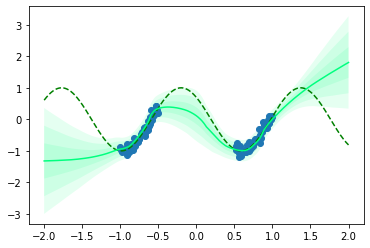

In [117]:
inputs=torch.linspace(-2.,2.,500).unsqueeze(-1).to(device)

(mu_star, sigma_star),sigma_e, sigma_a= test_hydranet_sigma(inputs, model)
plt.plot(inputs.cpu(), torch.cos(4.0*(inputs+0.2)).cpu(),'--',color='green')
plt.plot(inputs.cpu(), mu_star, color='springgreen')
for i in range(3):
    plt.fill_between(inputs.squeeze().cpu(), mu_star-(i+1)*sigma_star, mu_star+(i+1)*sigma_star, facecolor='springgreen', alpha=0.1)

plt.scatter(x_train.cpu(),y_train.cpu())

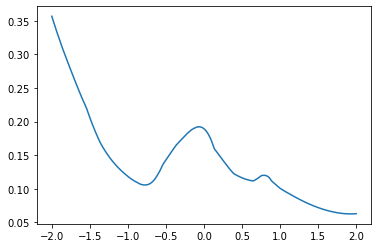

In [118]:
plt.plot(inputs.cpu(),sigma_a)

torch.Size([1000])
torch.Size([1000])


Text(0.5, 0, 'Uncertainty (Diff Entropy)')

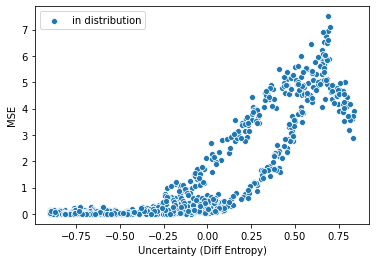

In [119]:
import seaborn as sns
X=[X_all]#[X_in,X_middle,X_out]
y=[y_all]#[y_in,y_middle,y_out]


Hs=[]
AEs=[]
for i in range(len(X)):
    (mu_star, sigma_star),sigma_e, sigma_a= test_hydranet_sigma(X[i].view(-1,1), model)

    H=torch.distributions.normal.Normal(torch.as_tensor(mu_star),torch.as_tensor(sigma_star)).entropy()
    
    print(H.shape)
    Hs.append(H)
    
    MSE=(std_y_train*(torch.as_tensor(mu_star).to(device)-y[i].squeeze())**2)
    L1error=(std_y_train*(pred.mean(0).squeeze()-y[i].squeeze()).abs())
    print(MSE.shape)
    AEs.append(L1error)
    ax=sns.scatterplot(H.cpu().numpy(),MSE.cpu().numpy(), label=label[i])
    
ax.set_ylabel('MSE')
ax.set_xlabel('Uncertainty (Diff Entropy)')


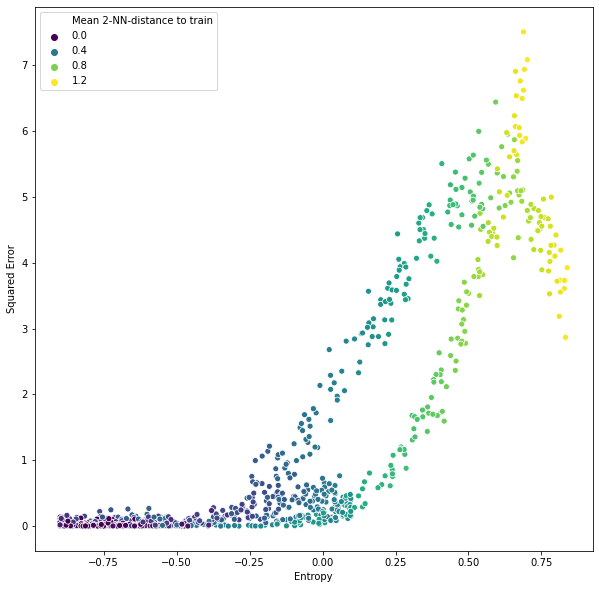

In [120]:
data=[]
for i in range(len(X_all)):
    data.append({'Entropy':H[i].item(), 'Squared Error':MSE[i].item(), 'Mean 2-NN-distance to train':knn[i].item()})

df=pd.DataFrame(data=data)
colors=knn.div_(knn.max())
colors

plt.subplots(figsize=(10,10))
sns.scatterplot(data=df, x='Entropy', y='Squared Error', hue='Mean 2-NN-distance to train', palette=cmap)

# T-SNE

In [82]:
theta_all=torch.cat([theta.detach(),GeN(1000).detach()])
labels=torch.cat([torch.zeros(10),torch.ones(1000)])


In [83]:

from sklearn.manifold import TSNE
myTSNE=TSNE(n_components=2,perplexity=100)
X_embedded_p =myTSNE.fit_transform(theta_all.cpu())
print(myTSNE.kl_divergence_)
X_embedded_p.shape

0.7921887636184692


(1010, 2)

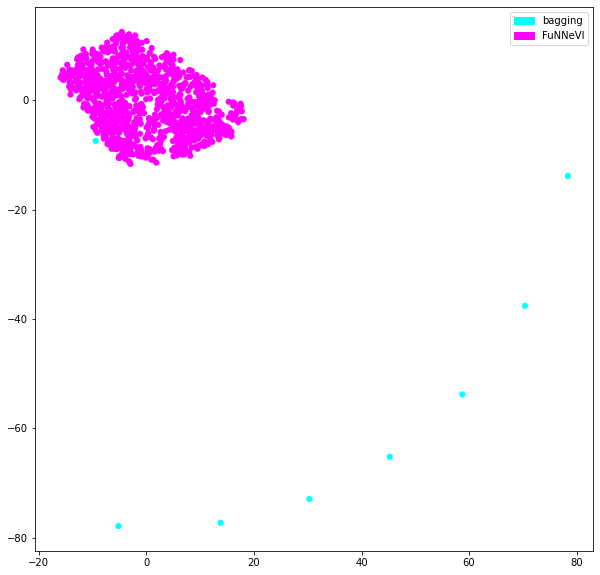

In [84]:
%matplotlib inline

import matplotlib.patches as mpatches

from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

import matplotlib.cm as cm
cmap = cm.cool

fig = plt.figure(figsize=(10, 10))
plt.scatter(X_embedded_p[:,0],X_embedded_p[:,1], linewidth=0.2, c=cmap(labels.numpy()), cmap=cmap)
#plt.title('3D t-SNE of '+str(param_count)+'-dimensional transformed noise')


G1_patch = mpatches.Patch(color=cmap(.0), label='bagging')
G2_patch = mpatches.Patch(color=cmap(1.), label='FuNNeVI')
#G3_patch = mpatches.Patch(color=cmap(.2), label='G3')

#PT_c=torch.tensor(0.1*(ensemble_size+2)).float()
#HMC_c=torch.tensor(0.1*(ensemble_size+4)).float()

#PTMCMC_patch = mpatches.Patch(color=cmap(PT_c), label='PTMCMC')
#HMC_patch = mpatches.Patch(color=cmap(HMC_c), label='HMC')
plt.legend(handles=[G1_patch,G2_patch])
#plt.legend(handles=[G1_patch,G2_patch,G3_patch,PTMCMC_patch,HMC_patch])

plt.show()


torch.Size([60, 1321])


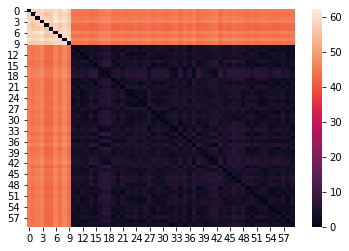

In [87]:
thetas=torch.cat([theta.detach(),GeN(50).detach()])
print(thetas.shape)
m=torch.cdist(thetas,thetas)
m.shape
sns.heatmap(m.cpu().numpy())